### If we define partitions by the threshold of the preferred belief (or the BSV), what should be the threshold that maximizes across-class variance explained (minimizes within-class variance)?

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import pandas as pd
from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)
import utils.behavioral_utils as behavioral_utils
import utils.spike_utils as spike_utils
import utils.io_utils as io_utils
import os
from distutils.util import strtobool

import argparse
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
from scripts.anova_analysis.anova_configs import *
from constants.behavioral_constants import *


### Load data

In [2]:
sub = "SA"
SESSIONS_PATH = "/data/patrick_res/sessions/{sub}/valid_sessions.pickle"
valid_sess = pd.read_pickle(SESSIONS_PATH.format(sub=sub))
beh = pd.concat(valid_sess.apply(lambda x: behavioral_utils.get_valid_belief_beh_for_sub_sess(sub, x.session_name), axis=1).values)

In [3]:
def load_beh(sub):
    valid_sess = pd.read_pickle(SESSIONS_PATH.format(sub=sub))
    beh = pd.concat(valid_sess.apply(lambda x: behavioral_utils.get_valid_belief_beh_for_sub_sess(sub, x.session_name), axis=1).values)
    return beh


def assign_belief_label(beh, thresh, mode):
    if mode == "pref":
        beh["BeliefLabel"] = beh.apply(lambda x: f"High {x.PreferredBelief}" if x.PreferredBeliefProb > thresh else "Low", axis=1)
    else: 
        beh["BeliefLabel"] = beh.apply(lambda x: f"High {x.PreferredBelief}" if x.BeliefStateValue > thresh else "Low", axis=1)
    return beh

def compute_across_label_var(beh, thresh, mode):
    beh = assign_belief_label(beh, thresh, mode)
    def compute_mean_probs(group):
        return group[[f"{feat}Prob" for feat in FEATURES]].mean()
    mean_probs = beh.groupby("BeliefLabel", as_index=False).apply(compute_mean_probs)
    summed_var = mean_probs[[f"{feat}Prob" for feat in FEATURES]].var().sum()    
    return summed_var

def compute_ratio_low_high(beh, thresh, mode):
    beh = assign_belief_label(beh, thresh, mode)
    counts = beh.groupby("BeliefLabel", as_index=False).TrialNumber.count()
    ratio = counts[counts.BeliefLabel == "Low"].iloc[0].TrialNumber / counts[counts.BeliefLabel != "Low"].TrialNumber.mean()
    return ratio



### Maybe try to maximize across-class variance between 13 classes, low, high-X. 
NOTE: ignore covariances, just add variance across each of the feature beliefs together. (treat as independent)

Conclusion: Threshold found is very high belief, high value, not sure if useful

In [13]:
pref_thresholds = np.arange(0.05, 0.9, 0.03)
pref_vars = []
for thresh in tqdm(pref_thresholds):
    pref_vars.append(compute_across_label_var(beh, thresh, "pref"))

val_thresholds = np.arange(0.3, 0.6, 0.03)
val_vars = []
for thresh in tqdm(val_thresholds):
    val_vars.append(compute_across_label_var(beh, thresh, "value"))


  0%|          | 0/29 [00:00<?, ?it/s]

 86%|████████▌ | 25/29 [00:09<00:01,  2.52it/s]


KeyboardInterrupt: 

Text(0.5, 0.98, 'Across class variance in low/high-X classes with different threshold choices')

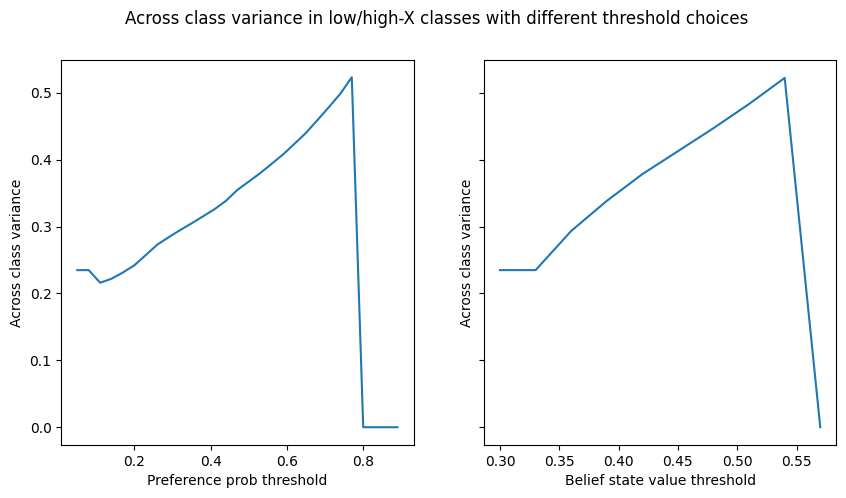

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
ax1.plot(pref_thresholds, pref_vars)
ax1.set_xlabel("Preference prob threshold")
ax1.set_ylabel("Across class variance")

ax2.plot(val_thresholds, val_vars)
ax2.set_xlabel("Belief state value threshold")
ax2.set_ylabel("Across class variance")
fig.suptitle("Across class variance in low/high-X classes with different threshold choices")

### What about balancing trials? Look at ratio between low class and average high-X class. See when it hits 1

In [28]:
pref_thresholds = np.arange(0.1, 0.4, 0.01)
pref_ratios = []
for thresh in tqdm(pref_thresholds):
    pref_ratios.append(compute_ratio_low_high(beh, thresh, "pref"))

val_thresholds = np.arange(0.34, 0.45, 0.01)
val_ratios = []
for thresh in tqdm(val_thresholds):
    val_ratios.append(compute_ratio_low_high(beh, thresh, "value"))


100%|██████████| 11/11 [00:03<00:00,  3.10it/s]


Text(0.5, 0.98, 'ratio between low class and average high-X class')

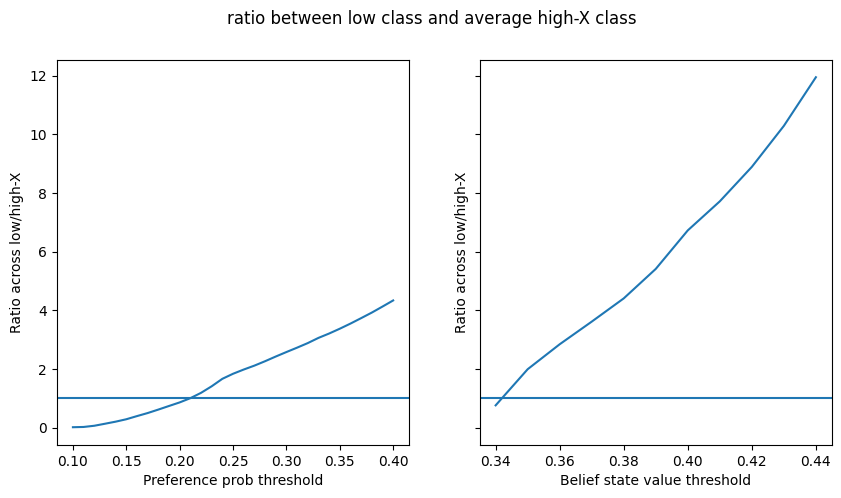

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5), sharey=True)
ax1.plot(pref_thresholds, pref_ratios)
ax1.axhline(1)
ax1.set_xlabel("Preference prob threshold")
ax1.set_ylabel("Ratio across low/high-X")

ax2.plot(val_thresholds, val_ratios)
ax2.axhline(1)

ax2.set_xlabel("Belief state value threshold")
ax2.set_ylabel("Ratio across low/high-X")
fig.suptitle("ratio between low class and average high-X class")

### What about reducing variance of entropy

In [41]:
probs = beh[[f"{feat}Prob" for feat in FEATURES]].values
beh["Entropy"] = -1 * np.sum(probs * np.log(probs), axis=1)

pref_thresholds = np.arange(0.05, 0.9, 0.03)
res = []
for thresh in tqdm(pref_thresholds):
    labeled = assign_belief_label(beh, thresh, mode).copy()
    labeled["thresh"] = thresh
    labeled["class"] = labeled["BeliefLabel"].apply(lambda x: "High" if x != "Low" else "Low")
    res.append(labeled)
res = pd.concat(res)


100%|██████████| 29/29 [00:11<00:00,  2.45it/s]


In [46]:
ent_vars = res.groupby(["class", "thresh"]).Entropy.var().reset_index(name="Entropy Variance")

<Axes: xlabel='thresh', ylabel='Entropy'>

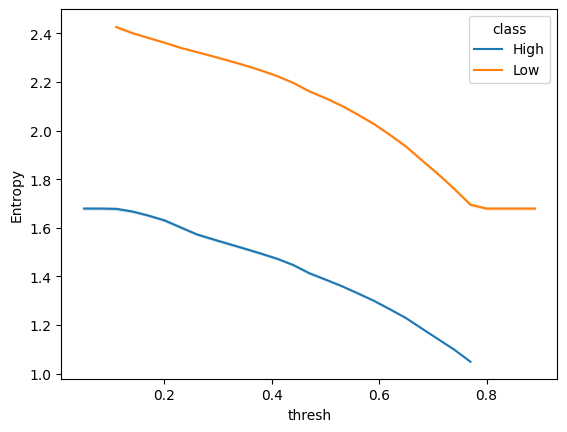

In [43]:
sns.lineplot(res, x="thresh", y="Entropy", hue="class")

<Axes: xlabel='thresh', ylabel='Entropy Variance'>

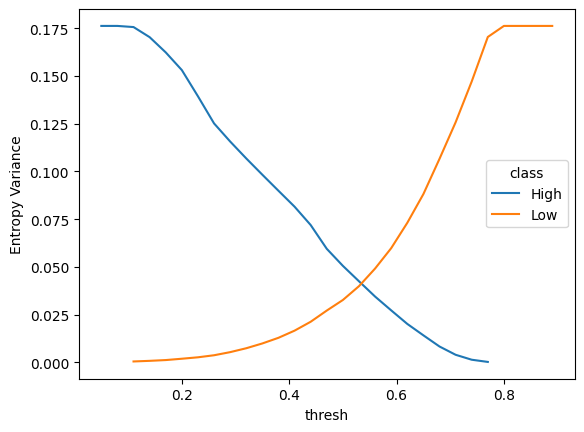

In [48]:
sns.lineplot(ent_vars, x="thresh", y="Entropy Variance", hue="class")

<Axes: xlabel='SQUAREProb', ylabel='RIPPLEProb'>

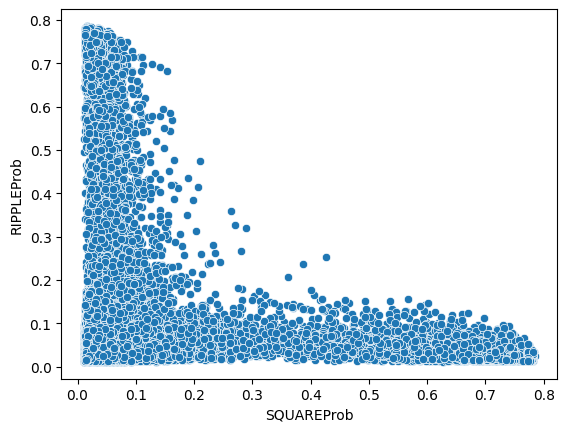

In [51]:
sns.scatterplot(beh, x="SQUAREProb", y="RIPPLEProb")

### At what probability threshold does the prob of only having one feature at that thresh reach 0

100%|██████████| 50/50 [00:46<00:00,  1.07it/s]


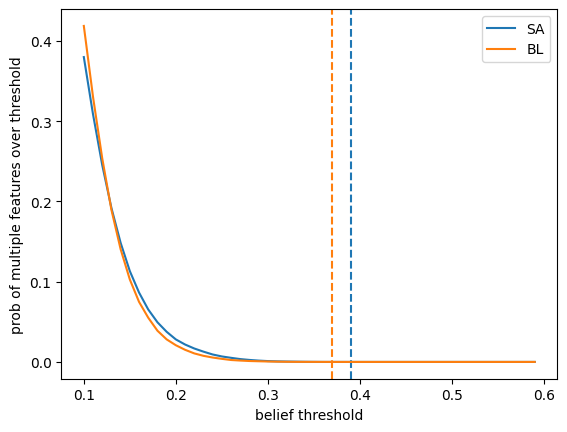

In [19]:
fig, ax = plt.subplots()

for sub in ["SA", "BL"]:
    beh = load_beh(sub)

    thresholds = np.arange(0.1, 0.6, 0.01)
    ratios = []

    for thresh in tqdm(thresholds): 
        beh["num_feat_thresh"] = beh.apply(lambda x: len([feat for feat in FEATURES if x[f"{feat}Prob"] > thresh]), axis=1)
        ratio = len(beh[beh.num_feat_thresh > 1]) / len(beh)
        ratios.append(ratio)
    zero_idx = np.argwhere(np.isclose(ratios, 0.0))[0, 0]
    zero_thresh = thresholds[zero_idx]
    line, = ax.plot(thresholds, ratios, label=sub)
    ax.axvline(zero_thresh, linestyle="--", color=line.get_color())

ax.set_xlabel("belief threshold")
ax.set_ylabel("prob of multiple features over threshold")
ax.legend()

### What does the trial balance look like for each belief threshold?
- look at single feature at a time: 
- what if we filtered for: correct, feature chosen, preferred chosen (in high trials)
- plot average number of trials per condition: low, high pref X, high not pref X. 

In [4]:
def label_row(x, thresh):
    if x.PreferredBeliefProb < thresh:
        return "Low"
    elif x.FeatPreferred == "Preferred":
        return "High Pref"
    else: 
        return "High Not Pref"
    
def partition_feat_sess(all_beh, session, feat, thresh):
    beh = all_beh[all_beh.session == session].copy()
    beh["Choice"] = beh.apply(lambda x: "Chose" if x[FEATURE_TO_DIM[feat]] == feat else "Not Chose", axis=1)
    beh["FeatPreferred"] = beh["PreferredBelief"].apply(lambda x: "Preferred" if x == feat else "Not Preferred")
    beh["sess_feat"] = f"{session} {feat}"
    beh["BeliefLabel"] = beh.apply(lambda x: label_row(x, thresh), axis=1)
    return beh

def partition_by_feats(all_beh, feat_sessions, thresh):
    all_res = []
    for feat in tqdm(FEATURES):
        row = feat_sessions[feat_sessions.feat == feat].iloc[0]
        sessions = pd.Series(row.sessions)
        res = pd.concat(sessions.apply(lambda x: partition_feat_sess(all_beh, x, feat, thresh)).values)
        all_res.append(res)
    all_res = pd.concat(all_res)
    return all_res

In [5]:
sub = "SA"
SESSIONS_PATH = "/data/patrick_res/sessions/{sub}/valid_sessions.pickle"
FEATS_PATH = "/data/patrick_res/sessions/{sub}/feats_at_least_3blocks.pickle"

valid_sess = pd.read_pickle(SESSIONS_PATH.format(sub=sub))
feat_sessions = pd.read_pickle(FEATS_PATH.format(sub=sub))
all_beh = load_beh(sub)

  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:04<00:00,  2.76it/s]


<Axes: xlabel='num_trials', ylabel='Count'>

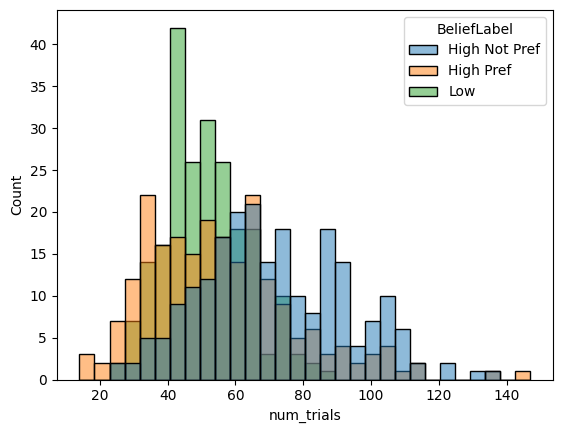

In [17]:
thresh = 0.5
all_res = partition_by_feats(all_beh, feat_sessions, thresh)


sub_res = all_res
sub_res = all_res[(all_res.Choice == "Chose") & (all_res.Response == "Correct")]
sub_res = sub_res[(sub_res.BeliefLabel == "Low") | (sub_res.PreferredChosen)]
grouped = sub_res.groupby(["sess_feat", "BeliefLabel"]).TrialNumber.nunique().reset_index(name="num_trials")

sns.histplot(grouped, x="num_trials", hue="BeliefLabel", bins=30)

### What is the average number of trials in each condition, across feat/session pairs, if we adjust the threshold?

In [13]:
thresholds = np.arange(0.1, 0.7, 0.05)
reses = []
for thresh in tqdm(thresholds):
    res = partition_by_feats(all_beh, feat_sessions, thresh)
    sub_res = res
    # sub_res = res[(res.Choice == "Chose") & (res.Response == "Correct")]
    # sub_res = sub_res[(sub_res.BeliefLabel == "Low") | (sub_res.PreferredChosen)]

    grouped = sub_res.groupby(["sess_feat", "BeliefLabel"]).TrialNumber.nunique().reset_index(name="num_trials")
    grouped["thresh"] = thresh
    reses.append(grouped)
reses = pd.concat(reses)

100%|██████████| 12/12 [00:13<00:00,  1.15s/it]


<Axes: xlabel='thresh', ylabel='num_trials'>

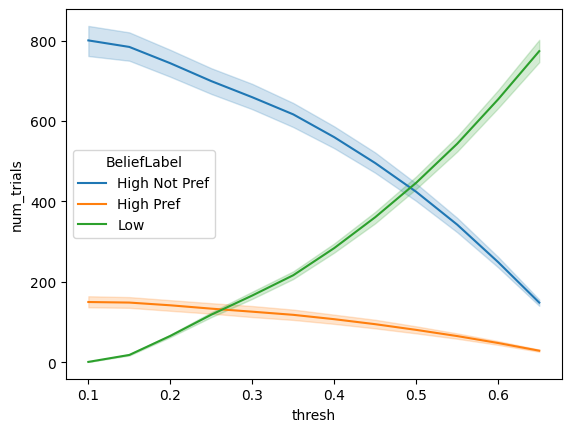

In [14]:
sns.lineplot(reses, x="thresh", y="num_trials", hue="BeliefLabel")

High pref: beliefs of X over thresh, chose a card with X, 
High not pref: belief of other feat over thresh, still chose card with X
Low: no beliefs over thresh

### What is the value bias in the different partitions?

In [18]:
thresh = 0.5
all_res = partition_by_feats(all_beh, feat_sessions, thresh)

  0%|          | 0/12 [00:00<?, ?it/s]

100%|██████████| 12/12 [00:05<00:00,  2.29it/s]


In [26]:
sub_res = all_res[all_res.BeliefLabel.isin(["High Not Pref", "High Pref"])]
sub_res = sub_res[(sub_res.Choice == "Chose") & (sub_res.Response == "Correct")]


<Axes: xlabel='BeliefStateValue', ylabel='Density'>

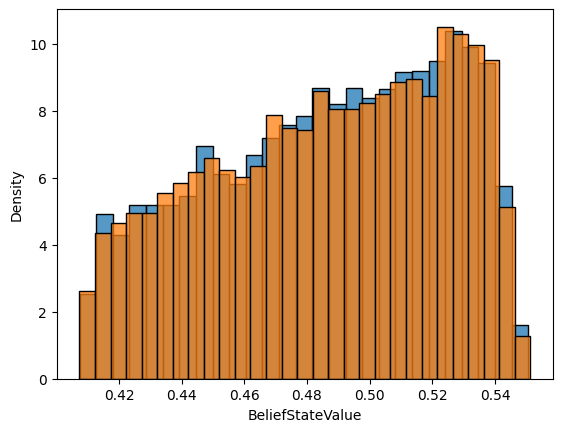

In [29]:
fig, ax = plt.subplots()
sns.histplot(sub_res[sub_res.BeliefLabel == "High Pref"], x="BeliefStateValue", stat="density", ax=ax)
sns.histplot(sub_res[sub_res.BeliefLabel == "High Not Pref"], x="BeliefStateValue", stat="density", ax=ax)

<Axes: xlabel='BeliefStateValue', ylabel='Density'>

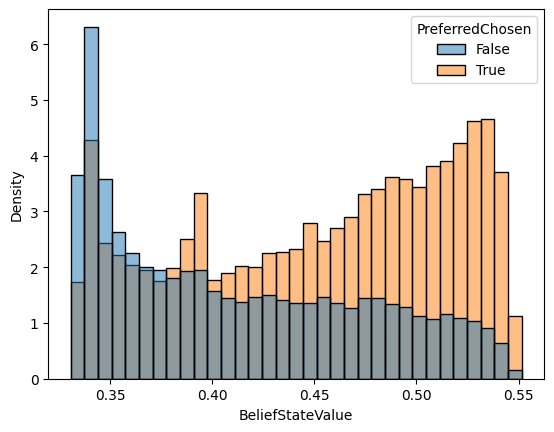

In [32]:
sns.histplot(all_beh, x="BeliefStateValue", stat="density", hue="PreferredChosen")
